In [1]:
import sys
import pickle
from scipy import signal
from scipy import stats
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import cohen_kappa_score

import math
from collections import OrderedDict


import matplotlib.pyplot as plt

sys.path.append('D:\Diamond\code')
from csp_james_2 import *

sys.path.append('D:\Diamond\code')
from thesis_funcs_19_03 import *

import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler

import csv
import datetime


In [2]:
meth = 'gold_stand' #gold_stand，tl_comp_csp_kld , tl_comp_csp_mi
#raw_data_root = 'E:\\Diamond\\bci_iv\\DATA\\2a\\extract_raw\\'
config_root= 'E:\\Diamond\\bci_iv\\MODELS\\fbcsp_mibif_cnn\\2a\\configs\\'

feature_root = 'E:\\Diamond\\own_expo\\pilot_test\\'
model_root = feature_root
save_root = model_root + 'eval\\'


#load in cv config grid
hp_names  =[] #all the hyper-parameter names to be validated
with open(config_root +'cv_config.csv', mode = 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    for row in csv_reader:
        hp_names.append((row[0]).strip())

with open(config_root +'_lambda_config.csv', mode = 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    for row in csv_reader:
        hp_names.append((row[0]).strip())
csv_file.close()



num_inits = 5
k_fold = 5

# initialize csp
m = 2# m is Nw in the paper "learning temporal information for brain-copmuter interface, Sakhavi et.al"
n_components = 2 * m  # pick some components
down_sample_step = 10 #Hilbert evelope
# select Ns pairs of csp filters
Ns = 4

CLASSES =[0,1]

C_OVR = [0,1]

balance_classes = 1

########################################################################################################################
                                            # DEFINE FILTER BANK
########################################################################################################################
#Filter Bank
FB = [[4., 8.], [8., 12.], [12., 16.], [16., 20.], [20., 24.], [24., 28.], [28., 32.], [32., 36.], [36., 40.]]
FB = np.array(FB)

#argumaents for Chebyl II filtering
# Nyquist frequency

# min. attenuation in stop band
gstop = 45
# max. attenuation in passband
gpass= 5

#EEG_PERIOD = [[0.5,4]]
FS = [512]




In [3]:
to_save = 1

Signal_lens = ['05_15', '10_20', '15_25', '20_30', '25_35', '30_40'] + ['05_25', '10_30', '15_35', '20_40']

#csp_from = "own_csp\\"
csp_from = "carryover_4s_csp\\"

In [4]:
save_root  

'E:\\Diamond\\own_expo\\pilot_test\\eval\\'

In [5]:
for signal_len in Signal_lens:

    for portion_train in [1]:
        if to_save == 1:
            filewrite = open(save_root + csp_from + signal_len + '_' + str(int(portion_train*100))+'_best_config_eval_acc_all_subjects.txt', 'w')
            filewrite.write('')
            filewrite.close()

            filewrite = open(save_root + csp_from + signal_len + '_' + str(int(portion_train*100))+'_best_config_eval_acc_all_subjects.txt', 'a')
            filewrite.write('subject, ')
            for f in range (0, len(C_OVR)-1):
                filewrite.write('class '+ str(C_OVR[f]+1) + ', ')
            filewrite.write('class ' + str(C_OVR[-1]+1) + ', average'+ ', best_model_init_fold\n')


        for subject in range (3,4):

            sub_id = 's' + str(subject)

            #eeg_period = EEG_PERIOD[0]
            eeg_period = signal_len_to_eeg_period(signal_len)
            fs = FS[0]


            #csp_from is where the csp is from, using its own csp for eeg_period seconds, or 4s_carryover_csp
            file_root_feature =  feature_root + sub_id + '\\models\\' + csp_from + signal_len + '\\pt_' + str(int(portion_train*100))
            file_root_model = model_root + sub_id + '\\models\\' + csp_from + signal_len + '\\pt_' + str(int(portion_train*100))
            

            ###################################################################################################################
                            #load best config
            ###################################################################################################################
            #load in best config line
            config_file = open(file_root_model + '\\ANN\\best_config_val.txt', 'r')
            config_log= config_file.readlines()
            config_file.close()
            for i in range (0,len(config_log)):
                line  = config_log[(i + 1) * -1]
                if '_act_fun_' in line: #and  line.split(' ')[0].split('_lambda_')[1] == '0':
                    break

            #extract best config values and make into dictionary
            config = OrderedDict()
            for hp_ind in range(0, len(hp_names)-1):
                config[hp_names[hp_ind]] =  (line.split(hp_names[hp_ind] + '_')[1].split('_'+hp_names[hp_ind+1]+'_')[0])
            config[hp_names[-1]] = line.split(hp_names[-1]+'_')[1].split(' ')[0]


            
            ## LOAD in raw EEG(MI) portion and LABELS
            EEG_MI_RAW_load = pickle.load(open( 'E:\\Diamond\\own_expo\\pilot_test\\' + sub_id + '\\signals\\' + sub_id + ".pickle", "rb" ) )
            LABELS_load = pickle.load(open( 'E:\\Diamond\\own_expo\\pilot_test\\' + sub_id + '\\signals\\' + sub_id + "_LABELS.pickle", "rb" ) )
            #seperate the raw EEG into training and evaluaiton sets
            EEG_MI_RAW_T, LABELS_load_T, EEG_MI_RAW_E, LABELS_load_E= seperate_train_eval_ind(EEG_MI_RAW_load, LABELS_load)
            LABELS = LABELS_load_E - 1
            EEG_extract_raw = EEG_MI_RAW_E
            ########################################################################################################################
                                        #APPLY FILTER BANK
            ########################################################################################################################
            #Store Filter bank filtered raw EEG data, in the shape of num_filter_bank X num_trials X num_chanl X num_samples
            #initiate empty matrix
            EEG_filt_FB_L = np.empty( [len(FB), 
                                     np.shape(EEG_extract_raw)[0], np.shape(EEG_extract_raw)[1],np.shape(EEG_extract_raw)[2]] )

            Nf = fs / 2.
            for fb in range (0, len(FB)):
                passband = FB[fb]
                stopband = FB[fb] + np.array([-2., +2.])

                EEG_filt_FB_L[fb] = filter_signal(EEG_extract_raw, passband, stopband, Nf, gpass, gstop)


            EEG_filt_FB = EEG_filt_FB_L

            #trake only the MI 3.5 seconds
            EEG_filt_FB_go = EEG_filt_FB[:,:,:,int(eeg_period[0]*fs):int(eeg_period[1]*fs)]
            LABELS0_go = LABELS.copy()
            LABELS0 = LABELS0_go

            ###########################################################################################################################

            pred_indi = []
            ############################################################################################################################
            OUT = 0

            best_mod_acc_prod = 0 #initialise best model average class acc
            best_mod_kappa = -2
            best_model = [0,0] #which model performs the best? model id, init = best_model[0], fold = best_model[1]

            for fold in range (0, k_fold):
                #print ('fold', fold)

                pred_indi.append([])

                for c_ovr in C_OVR:
                    #print (c_ovr)
                    #load in csp filters and mutual informtaion ranked indicies
                    W_B = pickle.load(open( file_root_feature +'\\W_B_fold_' + str(fold) + 
                                               '_c_ovr_' + str(c_ovr) + '_lambda_' + str(float(config['_lambda'])) + 
                                               ".pickle", 'rb'))


                    FB_FILTER_IND = pickle.load(open( file_root_feature +  '\\FB_FILTER_IND_fold_' + str(fold) + 
                                               '_c_ovr_' + str(c_ovr) + '_lambda_' + str(float(config['_lambda'])) + 
                                               ".pickle", 'rb'))

                    #find the selected csp filters indicies
                    FB_FILTER_IND_slt = find_selected_csp_filters(Ns, m, FB_FILTER_IND)

                    #construct selected csp filters, W_B_slt has shape (2*Ns, num_chls), (8,22) for example
                    W_B_slt = W_B[FB_FILTER_IND_slt[:,0], :, FB_FILTER_IND_slt[:,1]]

                    EEG_FB_slt = EEG_filt_FB_go[FB_FILTER_IND_slt[:,0],:]

                    #transform into z space, then take the hilbert envelope of the transformed signal
                    Z_env = calc_z_features(W_B_slt, EEG_FB_slt, Ns, down_sample_step)

                    #concatenate all classes
                    if c_ovr == C_OVR[0]:
                        Z_all_eval = Z_env
                    else:
                        Z_all_eval = np.concatenate((Z_all_eval, Z_env), axis = 0)

                #reshape into ANN input size        
                Z_all_eval = np.transpose(Z_all_eval, [1,0,2])
                X_eval = np.reshape(Z_all_eval, [np.shape(Z_all_eval)[0], 1, np.shape(Z_all_eval)[1], np.shape(Z_all_eval)[2]])
                X_eval = torch.from_numpy(X_eval).float()

                #initilize ANN model
                model = Model_current(chn_inp = X_eval.size()[-2], len_inp = X_eval.size()[-1], nf = int(config['nf']), ks = int(config['ks']) , 
                                  stride = int(config['stride']), act_f = config['act_fun'], nfc = int(config['nfc']))

                for n_inits in range (0, num_inits):
                    save_path = file_root_model + '\\ANN\\model_config_'+ line.split(' ')[0] + '_n_inits_'+ str(n_inits) +'_fold_' + str(fold) + '.pt'
                    model.load_state_dict(torch.load(save_path))
                    model.eval()

                    #predictoin, sum up the output (probability of being class) predicted at each fold, tehn the class with the max probability if the class prediction
                    out = model(X_eval)
                    OUT = OUT + out

                    #print out class precition at each fold
                    pred = torch.argmax(out, dim = 1).numpy()
                    #print (str(n_inits), np.average(calc_class_acc(pred, LABELS0, C_OVR)))
                    if cohen_kappa_score(LABELS0, pred) > best_mod_kappa:
                        best_model = [n_inits, fold]
                        best_mod_acc_prod = np.average(calc_class_acc(pred, LABELS0, C_OVR))
                        best_mod_kappa = cohen_kappa_score(LABELS0, pred)

                    #pred_indi[fold].append(cohen_kappa_score(LABELS0, pred))


            #final prediciotn using all trained ANNs   
            PRED = torch.argmax(OUT, dim = 1).numpy()
            acc_c = calc_class_acc(PRED, LABELS0, C_OVR)
            print(sub_id, acc_c, np.average(acc_c))
            kappa = cohen_kappa_score(LABELS0, PRED)

            if to_save == 1:
                filewrite.write(str(subject) + ', ')

                for a in acc_c:
                    filewrite.write(str(round(a*100,2)) + ', ')
                filewrite.write(str(round(np.average(acc_c)*100, 2)) +' '+'('+str(round(kappa, 3))+')' +', ' + str(best_model[0])+'_'+str(best_model[1]) + '_'+ str(best_mod_acc_prod) + '(' + str(best_mod_kappa) + ')'  +'\n')


        if to_save == 1:
            filewrite.close()

D:\THINKPAD\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
D:\THINKPAD\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1593: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]
D:\Diamond\code\thesis_funcs_19_03.py:1510: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nnF.softmax(self.fc3(x))


s3 [0.8        0.76666667] 0.7833333333333334
s3 [0.76666667 0.7       ] 0.7333333333333334
s3 [0.83333333 0.53333333] 0.6833333333333333
s3 [0.76666667 0.83333333] 0.8
s3 [0.53333333 0.83333333] 0.6833333333333333
s3 [0.86666667 0.56666667] 0.7166666666666667
s3 [0.83333333 0.8       ] 0.8166666666666667
s3 [0.86666667 0.66666667] 0.7666666666666666
s3 [0.7        0.86666667] 0.7833333333333333
s3 [0.76666667 0.9       ] 0.8333333333333334


In [8]:
Signal_lens_all = ['05_15', '10_20', '15_25', '20_30', '25_35', '30_40'] + ['05_25', '10_30', '15_35', '20_40']

In [9]:
Signal_lens_all

['05_15',
 '10_20',
 '15_25',
 '20_30',
 '25_35',
 '30_40',
 '05_25',
 '10_30',
 '15_35',
 '20_40']

In [11]:
cv_root = 'E:\\Diamond\\own_expo\\pilot_test\\' + sub_id + '\\models\\carryover_4s_csp\\' 
Best_acc = []
for signal_len in Signal_lens_all:
    best_cv_file_path = cv_root + signal_len + '\\pt_100\\ANN\\best_config_val.txt'
    Best_acc.append(get_best_cv_acc (best_cv_file_path))

In [12]:
cv_root

'E:\\Diamond\\own_expo\\pilot_test\\s3\\models\\carryover_4s_csp\\'

In [13]:
def get_best_cv_acc (best_cv_file_path):
    best_cv_file = open(best_cv_file_path, 'rb')
    best_config = best_cv_file.readlines()
    best_acc = float(str(best_config[0]).split(' ')[1])
    best_cv_file.close()
    return best_acc

In [14]:
best_acc

NameError: name 'best_acc' is not defined

In [51]:
Best_acc

[0.5479999999999999,
 0.6306666666666666,
 0.5986666666666667,
 0.556,
 0.6133333333333334,
 0.6146666666666667,
 0.6986666666666668,
 0.7253333333333333,
 0.608,
 0.66]

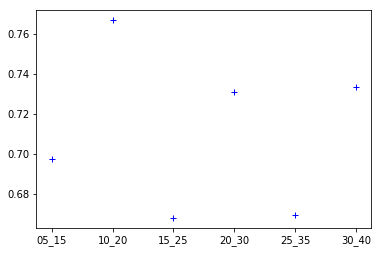

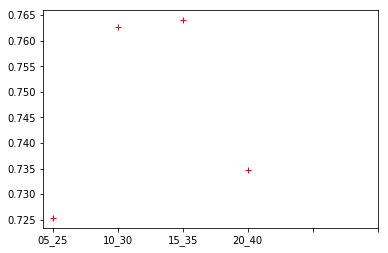

In [15]:

locs = np.arange(1,len(Signal_lens_all) + 1)
plt.plot(locs[0:-4], Best_acc[0:-4], 'b+')
plt.xticks(locs[0:-4], Signal_lens_all[0:-4])
plt.show()

plt.plot(locs[0:4], Best_acc[-4:], 'r+')
plt.xticks(locs[0:-4], Signal_lens_all[-4:])
plt.show()

#plt.vlines(6.5, 0.5, 0.72)


In [61]:
len(Best_acc)

10